**Implementation of a DCNN for classifying CXR images of TB and Pneumonia**

The Implemented CNN is at the limit of what will fit in the zync-7000 FPGA (PYNQ-Z2 Board)

In [170]:
##Imports
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.layers import BatchNormalization
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import PIL
import cv2
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from qkeras.utils import _add_supported_quantized_objects
import hls4ml
import plotting
import plotting
from sklearn.metrics import accuracy_score
import time
# import plotting
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

In [171]:
##Read Images and convert to numpy arrays
path_normal = './Datasets/Normal/'
path_pneumonia = './Datasets/pneumonia/'
path_tb = './Datasets/Tuberculosis/'
data1 = list()
data2 = list()
data3 = list()
x = list()
for image in os.walk(path_normal):
  data1.append(image[2])

for i in range(len(data1[0])): #data1 is a list containing a list of file names. so, data1[0] is list of file names.
  str_complete = path_normal + data1[0][i]
  img = cv2.imread(str_complete) #It loads the image as a NumPy array.
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (128, 128))
  x.append(img)
  # print(i)

print(f"{len(x)} Images Loaded")
##Class-2 images##
for image in os.walk(path_pneumonia):
  data2.append(image[2])

for i in range(len(data2[0])):
  str_complete = path_pneumonia + data2[0][i]
  img = cv2.imread(str_complete)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (128, 128))
  x.append(img)#Ensure all images are loaded
  # print(i)
print(f"{len(x)} Images Loaded")
##Class-3 images##
for image in os.walk(path_tb):
  data3.append(image[2])

for i in range(len(data3[0])):
  str_complete = path_tb + data3[0][i]
  img = cv2.imread(str_complete)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (128, 128))
  x.append(img)
  # print(i)##Ensure all images are loaded
print(f"{len(x)} Images Loaded")

data_x = np.asarray(x)
data_x.shape
full_dataset_x = data_x
full_dataset_y = np.zeros(2110)
y = np.zeros(2110)
y[:700] =1
y[700:1410]=2
y[1410:2110]=3
full_dataset_y = y
print(data_x.shape,y.shape)

full_dataset_y_onehot = np.zeros((np.array(full_dataset_y).shape[0],3))
for i in range(np.array(full_dataset_y).shape[0]):
  label = full_dataset_y[i]-1
  full_dataset_y_onehot[i][int(label)] = 1


x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size=0.2, random_state=1)#x_train has 80%, x_test has 20%
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/8, random_state=1)#x_train has 70%, x_val has 10%

#one-hot encoding
y_tr_one_hot  = np.zeros((np.array(y_train).shape[0],3))

for i in range(np.array(y_train).shape[0]):
  label = y_train[i]-1
  y_tr_one_hot[i][int(label)] = 1

y_val_one_hot  = np.zeros((np.array(y_val).shape[0],3))

for i in range(np.array(y_val).shape[0]):
  label = y_val[i]-1
  y_val_one_hot[i][int(label)] = 1

y_te_one_hot  = np.zeros((np.array(y_test).shape[0],3))

for i in range(np.array(y_test).shape[0]):
  label = y_test[i]-1
  y_te_one_hot[i][int(label)] = 1

700 Images Loaded
1410 Images Loaded
2110 Images Loaded
(2110, 128, 128) (2110,)


In [172]:
train_size = x_train.shape[0]
input_shape = (128,128,1)
n_classes = 3
batch_size = 64
train_data = (x_train, y_tr_one_hot)
print(x_train.shape)
train_data = tf.data.Dataset.from_tensor_slices(train_data)
train_data = train_data.shuffle(buffer_size=128).batch(batch_size)
val_data = (x_val, y_val_one_hot)
val_data = tf.data.Dataset.from_tensor_slices(val_data)
val_data = val_data.shuffle(buffer_size=128).batch(batch_size)


(1477, 128, 128)


In [173]:
import numpy as np

def shuffle_images_and_labels(images, labels):
    """
    Shuffles a set of images and their corresponding one-hot encoded labels.

    Parameters:
    images (numpy.ndarray): A NumPy array of shape (N, H, W) representing N images.
    labels (numpy.ndarray): A NumPy array of shape (N, C) representing one-hot encoded labels.

    Returns:
    shuffled_images (numpy.ndarray): Shuffled images array.
    shuffled_labels (numpy.ndarray): Shuffled labels array.
    """
    # Check if the number of images matches the number of labels
    if images.shape[0] != labels.shape[0]:
        raise ValueError("Number of images and labels must match.")

    # Generate random indices for shuffling
    num_samples = images.shape[0]
    indices = np.random.permutation(num_samples)

    # Shuffle both images and labels using the same random indices
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]

    return shuffled_images, shuffled_labels

full_dataset_x, full_dataset_y_onehot= shuffle_images_and_labels(full_dataset_x,full_dataset_y_onehot)

In [174]:
###Define model 
def define_model():
    filters_per_conv_layer = [4, 8, 8]
    neurons_per_dense_layer = [8, 16]
    
    x = x_in = Input((128,128,1))
    
    for i, f in enumerate(filters_per_conv_layer):
        print(('Adding convolutional block {} with N={} filters').format(i, f))
        x = Conv2D(
            int(f),
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_initializer='lecun_uniform',
            kernel_regularizer=l1(0.0001),
            use_bias=False,
            name='conv_{}'.format(i),
        )(x)
        x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
        x = Activation('relu', name='conv_act_%i' % i)(x)
        x = MaxPooling2D(pool_size=(3, 3), name='pool_{}'.format(i))(x)
    x = Flatten()(x)
    
    for i, n in enumerate(neurons_per_dense_layer):
        print(('Adding dense block {} with N={} neurons').format(i, n))
        x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
        x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
        x = Activation('relu', name='dense_act_%i' % i)(x)
    x = Dense(int(n_classes), name='output_dense')(x)
    x_out = Activation('softmax', name='output_softmax')(x)
    
    model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')
    
    model.summary()
    return model

In [175]:
NSTEPS = int(train_size * 0.9) // batch_size  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))


# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
        )
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

Number of training steps per epoch is 20


In [176]:
from keras import backend as K
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
from sklearn.metrics import cohen_kappa_score

def qwk(y_true, y_pred):
    return cohen_kappa_score(K.eval(y_true), K.eval(K.round(y_pred)), weights='quadratic')

In [177]:
def make_hls_model(unpruned_model):
    hls_config = hls4ml.utils.config_from_keras_model(unpruned_model, granularity='name')
    hls_config['Model']['Precision'] = 'ap_fixed<20,8>'
    hls_config['Model']['ReuseFactor'] = 64
    
    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Strategy'] = 'latency'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 64
        hls_config['LayerName'][Layer]['Precision'] = 'ap_fixed<20,8>'

    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Precision'] = "ap_uint<8>"
        break
    hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
    plotting.print_dict(hls_config)
    cfg = hls4ml.converters.create_config(backend='VivadoAccelerator')
    cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
    cfg['HLSConfig'] = hls_config
    cfg['KerasModel'] = unpruned_model
    cfg['OutputDir'] = './cxr_cnn/'
    cfg['board']='pynq-z2'

    hls_model = hls4ml.converters.keras_to_hls(cfg)
    hls_model.compile()
    return hls_model

In [178]:
def trainModel(model_pruned,training_data,val_data):
    train = True  # True if you want to retrain, false if you want to load a previsously trained model
    
    n_epochs = 30
    
    if train:
        LOSS = tf.keras.losses.CategoricalCrossentropy()
        OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
        # OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.0,nesterov=False) 

        
        model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy",keras.metrics.Precision(), keras.metrics.Recall(),f1_score])
    
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            pruning_callbacks.UpdatePruningStep(),
        ]
    
        start = time.time()
        model_pruned.fit(training_data[0],training_data[1], epochs=n_epochs,validation_data=val_data,callbacks=callbacks)
        end = time.time()
    
        print('It took {} minutes to train Keras model'.format((end - start) / 60.0))
    
        model_pruned.save('./xray_pruned_cnn.h5')
        return model_pruned
    
    else:
        from qkeras.utils import _add_supported_quantized_objects
        from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    
        co = {}
        _add_supported_quantized_objects(co)
        co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
        model_pruned = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)

In [179]:
def plotMetrics(Y, y_pred, y_pred_hls4ml, label="Model"):
    accuracy_keras = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred, axis=1)))
    accuracy_hls4ml = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred_hls4ml, axis=1)))

    precision_keras = float(precision_score(np.argmax(Y, axis=1),np.argmax(y_pred, axis=1), average='weighted'))
    precision_hls4ml = float(precision_score(np.argmax(Y, axis=1),np.argmax(y_pred_hls4ml, axis=1), average='weighted'))

    recall_keras = float(recall_score(np.argmax(Y, axis=1),np.argmax(y_pred, axis=1), average='weighted'))
    recall_hls4ml = float(recall_score(np.argmax(Y, axis=1),np.argmax(y_pred_hls4ml, axis=1), average='weighted'))

    f1_keras = float(sklearn.metrics.f1_score(np.argmax(Y, axis=1),np.argmax(y_pred, axis=1), average='weighted'))
    f1_hls4ml = float(sklearn.metrics.f1_score(np.argmax(Y, axis=1),np.argmax(y_pred_hls4ml, axis=1), average='weighted'))

    kappa_keras = float(cohen_kappa_score(np.argmax(Y, axis=1),np.argmax(y_pred, axis=1)))
    kappa_hls4ml = float(cohen_kappa_score(np.argmax(Y, axis=1),np.argmax(y_pred_hls4ml, axis=1)))
    
    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    print("Precision Keras:  {}".format(precision_keras))
    print("Precision hls4ml: {}".format(precision_hls4ml))
    print("Recall Keras:  {}".format(recall_keras))
    print("Recall hls4ml: {}".format(recall_hls4ml))
    print("F1 Keras:  {}".format(f1_keras))
    print("F1 hls4ml: {}".format(f1_hls4ml))
    print("Kappa Keras:  {}".format(kappa_keras))
    print("Kappa hls4ml: {}".format(kappa_hls4ml))

In [180]:
#Cross Validation:
from sklearn.model_selection import KFold


print('Number of training steps per epoch is {}'.format(NSTEPS))

train_data = (x_test,y_te_one_hot)

model  = trainModel(tf.keras.models.clone_model(define_model(), clone_function=pruneFunction),train_data,val_data)

scores = tmp_model.evaluate(x_test, y_te_one_hot, verbose=0)
print(f'Score for fold {fold_no}: {tmp_model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

hls_model = make_hls_model(strip_pruning(model))

y_predict = tmp_model.predict(x_test)    
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(x_test).astype(float)).astype(float)
plotMetrics(y_te_one_hot,y_predict,y_predict_hls4ml)

Number of training steps per epoch is 20
Adding convolutional block 0 with N=4 filters
Adding convolutional block 1 with N=8 filters
Adding convolutional block 2 with N=8 filters
Adding dense block 0 with N=8 neurons
Adding dense block 1 with N=16 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv_0 (Conv2D)             (None, 126, 126, 4)       36        
                                                                 
 bn_conv_0 (BatchNormalizati  (None, 126, 126, 4)      16        
 on)                                                             
                                                                 
 conv_act_0 (Activation)     (None, 126, 126, 4)       0         
                                                            

14/14 [==============================] - 0s 5ms/step
Accuracy Keras:  0.9881516587677726
Accuracy hls4ml: 0.943127962085308
Precision Keras:  0.9882984612589482
Precision hls4ml: 0.9443558919988283
Recall Keras:  0.9881516587677726
Recall hls4ml: 0.943127962085308
F1 Keras:  0.9881488373236181
F1 hls4ml: 0.943494582568541
Kappa Keras:  0.9822164535731444
Kappa hls4ml: 0.9146907455294345
[[138   0   1]
 [  0 147   0]
 [  4   0 132]]
[[131   0   8]
 [  1 140   6]
 [  8   1 127]]


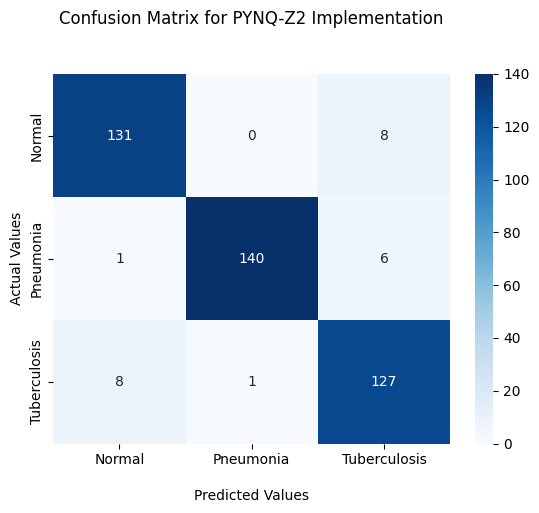

In [181]:
# Confusion Matrices.
import seaborn as sns

y_predict = tmp_model.predict(x_test)    
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(x_test).astype(float)).astype(float)
cm = confusion_matrix(np.argmax(y_te_one_hot, axis=1),np.argmax(y_predict, axis=1))
cm2 = confusion_matrix(np.argmax(y_te_one_hot, axis=1),np.argmax(y_predict_hls4ml, axis=1))
plotROC(y_te_one_hot,y_predict,y_predict_hls4ml)
print(cm)
print(cm2)
ax = sns.heatmap(cm2,annot=True,cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix for PYNQ-Z2 Implementation\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['Normal','Pneumonia','Tuberculosis'])
ax.yaxis.set_ticklabels(['Normal','Pneumonia','Tuberculosis'])
plt.show()

In [ ]:
import os

synth = True
if synth:
    hls_model.build(csim=False,export=True, bitfile=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/prabhav/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/prabhav/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'prabhav' on host 'zephy' (Linux_x86_64 version 5.15.0-91-generic) on Thu Dec 12 22:33:07 IST 2019
INFO: [HLS 200-10] On os Ubuntu 20.04.6 LTS
INFO: [HLS 200-10] In directory '/home/prabhav/CXR-FPGA-INF/cxr_cnn'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/prabhav/CXR-FPGA-INF/cxr_cnn/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file